In [ ]:
# --- BLOCK 1: IMPORTS & SETUP ---
import os
import numpy as np
import pandas as pd
import ast
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. SET THE PATH
DATA_ROOT = '/content/drive/MyDrive/IDDPedestrian'

if os.path.exists(DATA_ROOT):
    print(f"✅ Success! Found dataset at: {DATA_ROOT}")
else:
    print(f"❌ Error: Could not find folder at {DATA_ROOT}.")

🔄 Extracting Test Data from Pipeline into Memory...


NameError: name 'test_dataset' is not defined

In [ ]:
# --- BLOCK 2: CONTEXT FEATURE EXTRACTION (12-DIM) ---
from tqdm import tqdm

def get_refined_dataframe(root_path, sample_size=20000):
    # Using the same filename to ensure consistency with your previous workflow
    csv_path = os.path.join(root_path, 'idd_ped_12dim_context.csv')

    if os.path.exists(csv_path):
        print(f"✅ Found dataset at: {csv_path}")
        df = pd.read_csv(csv_path, converters={'meta': ast.literal_eval})
        print(f"   Loaded {len(df)} samples.")
    else:
        print("⚠️ Starting XML Parsing for 12-DIMENSIONAL Features...")
        samples = []
        annotations_dir = os.path.join(root_path, 'annotations')
        images_dir = os.path.join(root_path, 'images')

        xml_files = []
        for root, dirs, files in os.walk(annotations_dir):
            for file in files:
                if file.endswith('.xml'):
                    xml_files.append((root, file))

        for root, file in tqdm(xml_files, desc="Parsing XMLs"):
            xml_path = os.path.join(root, file)

            # Set ID logic
            set_id = 'unknown'
            if 'gp_set_' in root:
                parts = root.split(os.sep)
                for part in parts:
                    if part.startswith('gp_set_'):
                        set_id = part
                        break

            video_id = file.replace('.xml', '')
            rel_path = os.path.relpath(root, annotations_dir)
            current_img_dir = os.path.join(images_dir, rel_path, video_id)

            try:
                tree = ET.parse(xml_path)
                root_xml = tree.getroot()
            except:
                continue

            for track in root_xml.findall('track'):
                if track.attrib['label'] != 'pedestrian':
                    continue

                for box in track.findall('box'):
                    frame_id = int(box.attrib['frame'])
                    attrs = {a.attrib['name']: a.text for a in box.findall('attribute')}

                    # --- 1. TARGET LABEL ---
                    crossing_tag = attrs.get('Crossing', attrs.get('crossing', None))
                    cb_code = attrs.get('CrossingBehavior', attrs.get('CB', 'N/A'))
                    valid_crossing_codes = ['CD', 'CU', 'CFD', 'CFU']

                    if crossing_tag is not None:
                        label = int(crossing_tag)
                    else:
                        label = 1 if cb_code in valid_crossing_codes else 0

                    # --- 2. 12-DIMENSIONAL FEATURE VECTOR ---
                    # Pedestrian State
                    f_vuln = 0 if attrs.get('age') == 'adult' else 1
                    f_aware = 1 if attrs.get('AttentionIndicators', 'N/A') in ['LOS', 'FTT'] else 0
                    f_intent = 1 if attrs.get('TrafficInteraction', 'N/A') in ['WTT', 'HG'] else 0
                    f_social = 1 if attrs.get('SocialDynamics', 'N/A') in ['GS', 'CFA', 'AWC'] else 0

                    occ = box.attrib.get('occlusion', attrs.get('occlusion', '0'))
                    f_vis = int(occ) if occ in ['0', '1', '2'] else 0

                    # Environment
                    sig = attrs.get('SignalizedType', attrs.get('near_signal', 'N/A'))
                    f_infra = 1 if sig in ['S', 'CS', 'yes'] else 0

                    tod = attrs.get('Time of Day', attrs.get('TOD', 'day'))
                    f_night = 1 if 'night' in tod.lower() else 0

                    road = attrs.get('Road Type', attrs.get('RT', 'main'))
                    f_road = 1 if road in ['lane', 'secondary'] else 0

                    int_type = attrs.get('Intersection Type', attrs.get('IT', 'NI'))
                    f_inter = 0 if int_type == 'NI' else 1

                    # Location/Ego
                    loc = attrs.get('Location', 'N/A')
                    f_divider = 1 if 'divider' in loc.lower() else 0
                    f_side = 1 if 'side' in loc.lower() else 0
                    f_ego = int(attrs.get('Interaction Flag', attrs.get('IF', '0')))

                    meta_vector = [
                        f_vuln, f_aware, f_intent, f_social, f_vis,
                        f_infra, f_night, f_road, f_inter,
                        f_divider, f_side, f_ego
                    ]

                    # We verify image existence to match original dataset distribution
                    # but we do NOT load the image.
                    img_name_png = f"{frame_id:05d}.png"
                    img_name_jpg = f"{frame_id:05d}.jpg"
                    if os.path.exists(os.path.join(current_img_dir, img_name_png)) or \
                       os.path.exists(os.path.join(current_img_dir, img_name_jpg)):

                        samples.append({
                            'meta': meta_vector,
                            'label': label,
                            'set_id': set_id,
                            'video_id': video_id
                        })

        df = pd.DataFrame(samples)
        df.to_csv(csv_path, index=False)
        print(f"✅ Saved 12-dim dataset ({len(df)} samples) to: {csv_path}")

    # Sampling
    if len(df) > sample_size:
        df_sampled = df.sample(n=sample_size, random_state=42)
    else:
        df_sampled = df

    return df_sampled

# Execute
df = get_refined_dataframe(DATA_ROOT, sample_size=50000)
print(f"\n📊 Sample Meta Vector: {df.iloc[0]['meta']}")

🔄 Extracting Test Data from Pipeline into Memory...


NameError: name 'test_dataset' is not defined

In [ ]:
# --- BLOCK 3: OFFICIAL SPLIT & NUMERICAL PIPELINE ---

# 1. OFFICIAL SPLIT DEFINITION
TEST_SETS = ['gp_set_0003', 'gp_set_0005', 'gp_set_0008', 'gp_set_0009']

test_df = df[df['set_id'].isin(TEST_SETS)].copy()
dev_df = df[~df['set_id'].isin(TEST_SETS)].copy()

# Split Dev into Train/Val by Video ID (to prevent leakage)
unique_dev_videos = dev_df['video_id'].unique()
np.random.seed(42)
np.random.shuffle(unique_dev_videos)

split_idx = int(len(unique_dev_videos) * 0.8)
train_vids = unique_dev_videos[:split_idx]
val_vids = unique_dev_videos[split_idx:]

train_df = dev_df[dev_df['video_id'].isin(train_vids)].copy()
val_df = dev_df[dev_df['video_id'].isin(val_vids)].copy()

print(f"📊 Training:   {len(train_df)}")
print(f"📊 Validation: {len(val_df)}")
print(f"📊 Test:       {len(test_df)}")

# 2. PREPARE NUMPY ARRAYS (The MLP Input)
def prepare_data(dataframe):
    # Convert list of lists into a 2D numpy array
    X = np.stack(dataframe['meta'].values).astype(np.float32)
    y = dataframe['label'].values.astype(np.float32)
    return X, y

X_train, y_train = prepare_data(train_df)
X_val, y_val = prepare_data(val_df)
X_test, y_test = prepare_data(test_df)

# 3. CLASS WEIGHTS
neg = len(train_df[train_df['label']==0])
pos = len(train_df[train_df['label']==1])
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

# 4. TF DATASET (For efficient batching)
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

print(f"\n✅ Pipeline Ready. Input Shape: {X_train.shape[1]} dimensions.")
print(f"⚖️ Class Weights: {class_weights}")

🔄 Extracting Test Data from Pipeline into Memory...


NameError: name 'test_dataset' is not defined

In [ ]:
# --- BLOCK 4: MLP MODEL ARCHITECTURE ---

def build_mlp_model(input_dim=12):
    model = Sequential([
        Input(shape=(input_dim,)),

        # Layer 1: High capacity to learn feature interactions
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Layer 2: Bottleneck features
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Layer 3: Final refinement
        Dense(16, activation='relu'),

        # Output Layer: Sigmoid for binary classification
        Dense(1, activation='sigmoid')
    ])
    return model

model = build_mlp_model(input_dim=12)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,841 (15.00 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# --- BLOCK 5: TRAINING ---

checkpoint_path = os.path.join(DATA_ROOT, "best_idd_mlp.h5")

callbacks = [
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1),
    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

print("🚀 Starting MLP Training...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, # MLPs train fast, so we can do more epochs
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

🚀 Starting MLP Training...
Epoch 1/50
481/488 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4931 - auc: 0.5000 - loss: 0.6926
Epoch 1: val_loss improved from inf to 0.67723, saving model to /content/drive/MyDrive/IDDPedestrian/best_idd_mlp.h5


488/488 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.4940 - auc: 0.5000 - loss: 0.6926 - val_accuracy: 0.7550 - val_auc: 0.5000 - val_loss: 0.6772 - learning_rate: 0.0010
Epoch 2/50
483/488 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4881 - auc: 0.5000 - loss: 0.6907
Epoch 2: val_loss did not improve from 0.67723
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4883 - auc: 0.5000 - loss: 0.6907 - val_accuracy: 0.7550 - val_auc: 0.5000 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 3/50
476/488 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3910 - auc: 0.5000 - loss: 0.6935
Epoch 3: val_loss did not improve from 0.67723
488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3933 - auc: 0.5000 - loss: 0.6935 - val_accuracy: 0.2450 - val_auc: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 4/50
481/488 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4032 - auc: 0.5000 - loss: 0.6920
Epoch 4: val_loss did not improve from 0.67723

Epoch 4: ReduceLROnPlateau reducing le


🔍 Evaluating Model on OFFICIAL TEST SET...
   • Test Accuracy: 73.10%
   • Test AUC:      0.5000
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

Not Crossing       0.73      1.00      0.84     10536
    Crossing       0.00      0.00      0.00      3877

    accuracy                           0.73     14413
   macro avg       0.37      0.50      0.42     14413
weighted avg       0.53      0.73      0.62     14413


🧠 CALCULATING FEATURE IMPORTANCE (Permutation Method)...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏆 Top Features Driving Decisions:
             Feature  Importance
0   Vulnerable (Age)         0.0
1   Awareness (Look)         0.0
2   Intent (Gesture)         0.0
3    Social Dynamics         0.0
4         Visibility         0.0
5     Infrastructure         0.0
6         Night Time         0.0
7          Road Type         0.0
8       Intersection         0.0
9            Divider         0.0
10      Side of Road         0.0
11   Ego Interaction         0.0


/tmp/ipython-input-2311404922.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


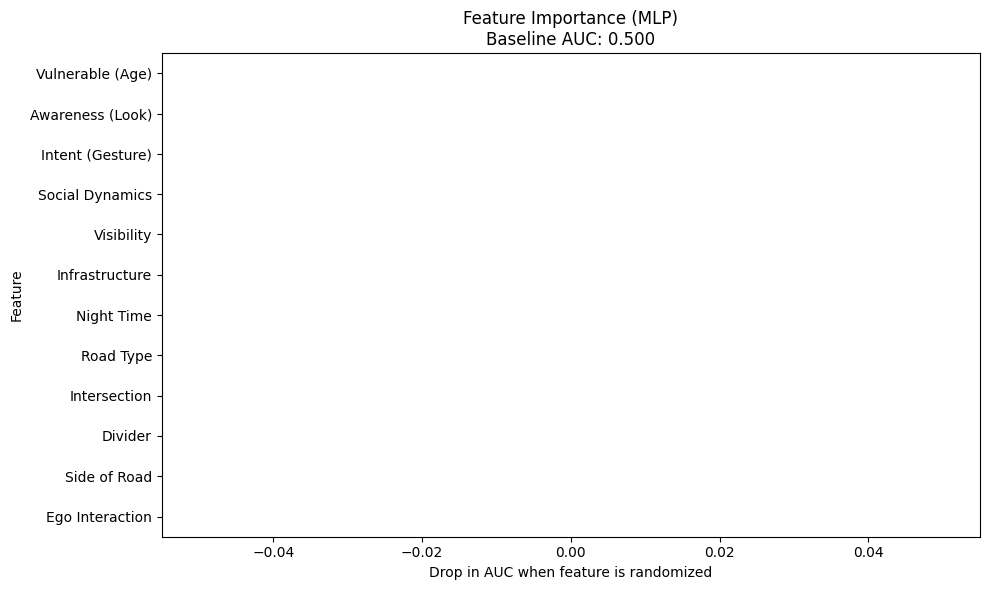


💡 INTERPRETATION:
   • High Positive Bar: This feature is CRITICAL. Randomizing it breaks the model.
   • Near Zero Bar: This feature is noise or redundant; the model ignores it.


In [ ]:
# --- BLOCK 6: TEST & FEATURE IMPORTANCE ---
import seaborn as sns

# 1. Standard Evaluation
print("\n🔍 Evaluating Model on OFFICIAL TEST SET...")
loss, acc, auc = model.evaluate(test_ds, verbose=0)
print(f"   • Test Accuracy: {acc:.2%}")
print(f"   • Test AUC:      {auc:.4f}")

# Get predictions
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

print("\n" + "="*50)
print("📊 CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Not Crossing', 'Crossing']))

# 2. FEATURE IMPORTANCE (Permutation Importance)
# We shuffle one column at a time and measure the drop in AUC
print("\n🧠 CALCULATING FEATURE IMPORTANCE (Permutation Method)...")

feature_names = [
    "Vulnerable (Age)", "Awareness (Look)", "Intent (Gesture)", "Social Dynamics",
    "Visibility", "Infrastructure", "Night Time", "Road Type",
    "Intersection", "Divider", "Side of Road", "Ego Interaction"
]

baseline_auc = roc_auc_score(y_test, y_pred_probs)
importances = []

for i in range(X_test.shape[1]):
    # Create a copy and shuffle one column
    X_test_permuted = X_test.copy()
    np.random.shuffle(X_test_permuted[:, i])

    # Predict again
    probs_permuted = model.predict(X_test_permuted, verbose=0).flatten()
    permuted_auc = roc_auc_score(y_test, probs_permuted)

    # Importance = How much did AUC drop?
    importance_score = baseline_auc - permuted_auc
    importances.append(importance_score)

# 3. VISUALIZATION
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n🏆 Top Features Driving Decisions:")
print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title(f"Feature Importance (MLP)\nBaseline AUC: {baseline_auc:.3f}")
plt.xlabel("Drop in AUC when feature is randomized")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("\n💡 INTERPRETATION:")
print("   • High Positive Bar: This feature is CRITICAL. Randomizing it breaks the model.")
print("   • Near Zero Bar: This feature is noise or redundant; the model ignores it.")